### Orchestrator-Worker
- The orchestrator–worker workflow in LangGraph is a design pattern you can use when building complex agentic applications. 
- Orchestrator: The “manager” or “controller” agent. It doesn’t directly do heavy work. Instead, it:
    - Receives the user query.
    - Decides which worker(s) should handle it.
    - Routes tasks to them (sometimes in parallel).
    - Collects and combines their responses.
    - Decides whether to continue, refine, or return the final answer.
- Worker(s): Specialized agents that perform specific subtasks.
Example: one worker might fetch from a database, another might summarize text, another might do API calls, etc.
- So basically:
    - Orchestrator = “brain/decision maker”
    - Worker(s) = “hands/doers”
- Why Use This Pattern?
    - Scalability: Easily extend by plugging in more workers.
    - Specialization: Each worker can be optimized for a narrow skill (retrieval, reasoning, math, calling APIs).
    - Control: The orchestrator enforces policies like “if confidence < threshold, escalate to human.”
    - Parallelization: Orchestrator can run multiple workers simultaneously.
- Example in LangGraph Terms
    - Imagine an insurance claims automation system (like the one you built 👌):
        1. Orchestrator node:
            - Reads user query: “Approve my claim for knee surgery.”
            - Decides the workflow.
        2. Worker nodes:
            - Document Validator Worker → Checks if all necessary documents are uploaded.
            - Fraud Detection Worker → Runs ML checks on past claims / suspicious activity.
            - Policy Checker Worker → Uses RAG to see if the claim is covered under inclusions/exclusions.
        3. Orchestrator:
            - Waits for worker outputs.
            - Aggregates them.
            - If fraud risk is low and policy covers surgery → approves automatically.
            - If anything is ambiguous → routes to “Human Review Worker.”
- LangGraph Implementation
    - LangGraph lets you model this with nodes & edges:
        - Nodes: Orchestrator, Worker1, Worker2, Worker3.
        - Edges: Orchestrator → Worker(s), Worker(s) → Orchestrator.
        - Routing: The orchestrator node decides which edges to activate dynamically at runtime.
- Pseudo-flow:  
    User → Orchestrator  
    Orchestrator → Worker A  
    Orchestrator → Worker B  
    Worker A → Orchestrator  
    Worker B → Orchestrator  
    Orchestrator → Final Output  

- The orchestrator is often implemented as a conditional edge function that routes to workers.
- Workers are often tool-using nodes or subgraphs.
- Real-World Use Cases
    - Customer support chatbot: Orchestrator decides → Billing Worker / Tech Support Worker / FAQ Worker.
    - RAG pipelines: Orchestrator decides → Retrieval Worker, Summarizer Worker, Verifier Worker.
    - Enterprise workflows: Orchestrator → HR Worker, IT Worker, Legal Worker.
- In short: The orchestrator-worker workflow in LangGraph is about modularizing an LLM system into a central decision-maker (orchestrator) and multiple specialized executors (workers), connected by graph routing.

In [5]:
# Imports
from typing import Annotated, List
import operator
from typing_extensions import TypedDict, Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
import os

In [6]:
# imports and load LLM
from dotenv import load_dotenv
load_dotenv()
# os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
api_key = os.getenv("OPENAI_API_KEY")
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(name="gpt-5-nano", api_key=api_key)
llm.invoke("What is machine learning?")

AIMessage(content='Machine learning is a field of artificial intelligence that involves the development of algorithms and models that allow computer systems to learn from and make predictions or decisions based on data patterns, without being explicitly programmed to do so. These algorithms can analyze large amounts of data, identify patterns, and make predictions or decisions without human intervention. Machine learning is used in a wide range of applications, including image and speech recognition, natural language processing, recommendation systems, and autonomous vehicles.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 12, 'total_tokens': 102, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id':

In [7]:
class Section(BaseModel):
    name: str = Field(description="Name for this section of the report")
    description: str = Field(description="Brief overview of the main topics and concepts of the section")

class Sections(BaseModel):
    sections: List[Section]=Field(
        description="Sections of the report"
    )
# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

c:\MyDrive\SelfStudyCode\AI\Krish\AgenticAI\venv\lib\site-packages\langchain_openai\chat_models\base.py:1906: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


### Creating workers dynamically in LangGraph
Because orchestrator-worker workflows are common, LangGraph has Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all the worker output and allows it to synthesize (combine) them into a final output.  
As you can see below, we can iterate over the list of Sections and send each to a worker node.

In [9]:
from langgraph.types import Send

# Graph state
class State(TypedDict):
    topic: str
    sections: list[Section]
    completed_sections: Annotated[list, operator.add]  # All workers write to this key in parallel
    final_report: str

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


In [10]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report"),
            HumanMessage(content=f"Here is the report topic: {state['topic']}")
        ]
    )

    print("Report Sections: ", report_sections)
    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""
    # Generate section
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."),
            HumanMessage(content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}")
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

# Conditional edge function to create llm_call workers that each write a section of the report
def assign_worker(state: State):
    """Assign a worker to each section in the plan"""
    # Kickoff section writng in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # For =mat completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

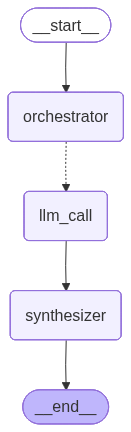

In [11]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges("orchestrator", assign_worker, ["llm_call"])
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile graph
orchestrator_worker = orchestrator_worker_builder.compile()

# View graph
graph_image = orchestrator_worker.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [12]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI RAGs"})

from IPython.display import Markdown
Markdown(state["final_report"])

Report Sections:  sections=[Section(name='Introduction', description='Introduce the concept of Agentic AI RAGs and provide a brief overview of their significance in the field of artificial intelligence.'), Section(name='Understanding Agentic AI RAGs', description='Explain what Agentic AI RAGs are, how they function, and their key characteristics. Discuss the role of RAGs in automated text generation and their potential applications.'), Section(name='Benefits of Agentic AI RAGs', description='Explore the advantages and benefits of using Agentic AI RAGs over traditional AI models. Highlight how RAGs improve text generation tasks and enhance user experiences.'), Section(name='Challenges and Limitations', description='Identify the challenges and limitations associated with Agentic AI RAGs. Discuss issues such as bias, ethical concerns, and potential misuse of RAGs in generating misinformation.'), Section(name='Future Prospects and Implications', description='Discuss the future prospects of

## Introduction

Agentic AI RAGs (Responsible AI Governance Frameworks) play a crucial role in ensuring ethical and responsible design, development, and deployment of artificial intelligence systems. These frameworks are designed to govern the behavior and decision-making of AI systems based on predefined rules, ethical guidelines, and societal values. Agentic AI RAGs focus on empowering AI systems to act responsibly and ethically, promoting trust and transparency in AI technologies.

They are essential in addressing challenges related to bias, fairness, accountability, and transparency in AI systems. By incorporating these frameworks into AI development processes, organizations can mitigate risks associated with AI technologies and ensure that AI systems align with legal, ethical, and social norms. Agentic AI RAGs are instrumental in promoting the adoption of AI technologies that benefit society while safeguarding against potential harms.

---

## Understanding Agentic AI RAGs

Agentic AI RAGs, short for "Retrieval-Augmented Generative models," combine both retrieval-based and generative models to improve the quality and coherence of generated text. These models have the capability to retrieve relevant information from a predefined knowledge source and then use it to enhance the generated output.

RAGs work by leveraging a retriever model to efficiently search a knowledge base for relevant information, which is then incorporated by the generative model during text generation. This approach helps RAGs produce more contextually accurate and informative content compared to traditional generative models.

Key characteristics of Agentic AI RAGs include their ability to understand and generate coherent text based on real-world knowledge, their flexibility in integrating external information sources for content enrichment, and their adaptability to various tasks and domains due to the retrieval mechanism.

In automated text generation, RAGs play a crucial role in improving the quality and relevance of generated content by enabling the model to access and incorporate external knowledge during the generation process. This not only enhances the accuracy and coherence of the text but also enables the model to generate more informative and contextually relevant outputs.

Some potential applications of RAGs include content creation for marketing and advertising, personalized recommendation systems, question-answering tasks, and dialogue systems where access to external knowledge sources is essential for generating high-quality responses.

---

## Benefits of Agentic AI RAGs

Agentic AI RAGs offer several benefits over traditional AI models, revolutionizing text generation tasks and enhancing user experiences. These advantages include:

1. **Enhanced Understanding of Context**: RAGs have the ability to comprehend and leverage context from a broader range of sources, including external sources like websites and databases. This allows for more coherent and relevant text generation compared to traditional AI models.

2. **Improved Answer Relevance**: By utilizing retriever models, RAGs can provide more accurate and contextually relevant answers to user queries. This significantly enhances the quality of information retrieval and synthesis.

3. **Increased User Interaction**: The interactive nature of RAGs engages users in a more dynamic and personalized conversation. This interactive approach not only improves user experience but also enables more precise responses to their queries.

4. **Expanded Knowledge Integration**: RAGs can tap into extensive external information sources to generate text, thus incorporating a vast array of knowledge beyond what is pre-programmed. This leads to richer and more informative output.

5. **Empowering Creativity**: Agentic AI RAGs empower users to become more creative in their interactions with AI systems. By providing users with greater control over the information retrieval process, RAGs enable them to explore and experiment with different perspectives and ideas.

Overall, the benefits of Agentic AI RAGs manifest in their ability to deliver more contextually relevant, interactive, and empowering text generation experiences compared to traditional AI models.

---

## Challenges and Limitations

- Agentic AI RAGs pose significant challenges and limitations, especially concerning bias. As these systems learn from existing data, they may perpetuate and amplify biases present in the data. This can result in the generation of biased or discriminatory content, which can have harmful consequences.

- Ethical concerns are also raised with Agentic AI RAGs, particularly regarding the ethical responsibility of developers and users in ensuring that the generated content is accurate, fair, and complies with ethical standards. The ability of these systems to create highly convincing and sophisticated content raises questions about authenticity and manipulation.

- One of the major limitations of Agentic AI RAGs is the potential misuse in generating misinformation. These systems can be exploited to create fake news, hoaxes, or propaganda, which can be spread rapidly through digital platforms and lead to widespread misinformation and social unrest. The challenge lies in distinguishing between authentic and manipulated content generated by AI RAGs.

- The rapid advancement of Agentic AI RAGs also outpaces regulatory frameworks and policies to govern their use effectively. This lack of regulation and oversight can pose challenges in monitoring and controlling the dissemination of content generated by these systems, leaving room for misuse and abuse.

---

## Future Prospects and Implications

Agentic AI RAGs have shown immense potential for transforming various industries and fields. In the future, advancements in Agentic AI RAGs could lead to even more sophisticated text generation capabilities, with improved natural language understanding and context analysis. This could enable the development of more personalized and interactive content, revolutionizing the way information is accessed and consumed.

The implications of these advancements are significant for AI research, as they could pave the way for more advanced AI systems capable of understanding and generating human-like text. This could lead to breakthroughs in natural language processing and cognitive computing, enhancing our understanding of human language and communication.

In terms of text generation technologies, the future prospects of Agentic AI RAGs could open up new possibilities for content creation, marketing strategies, and communication tools. Businesses could leverage these technologies to automate content generation, improve customer engagement, and streamline communication processes.

However, these advancements also raise important ethical considerations. As AI systems become more proficient at generating human-like text, there is a risk of misinformation, fake news, and manipulation. It will be crucial to establish guidelines and regulations to ensure that Agentic AI RAGs are used ethically and responsibly.

Overall, the future prospects of Agentic AI RAGs hold promise for advancing AI research, enhancing text generation technologies, and transforming society. By addressing ethical considerations and leveraging the potential of these technologies, we can harness their benefits while minimizing potential risks.